# $x^4$ Approximation 

### __Theory:__
The problem revolves around solving the Schrödinger Equation for $x^4$ perturbation:

$$ \left(\frac{1}{2m}\hat{p}^2 + \frac{1}{2}k\hat{x}^2 + \lambda x^4\right)\ket{\psi} = E\ket{\psi} \iff (\hat{H}_\text{osc} + \lambda \hat{x}^4)\ket{\psi} = E\ket{\psi}$$

We will solve this equation for the ground state, which means finding the lowest eigenvalue $E$ and its corresponding eigenstate $\ket{\psi}$.

Since the eigenstates of the QHO $\,\,\{\ket{n}\}_{n=1}^\infty\,\,$  form a basis for $L^2(\mathbb{R})$, we can assume that the groundstate takes the form:

$$\ket{\psi_0} = \sum_{n = 0}^\infty \alpha _n \ket{n} \qquad \alpha_i \in \mathbb{C}$$

which reduces the problem to that of finding the coefficients $\{\alpha_i\}_{i = 0}^\infty \,\,$. This can be presented as an optimization problem: It can be shown that $$E_0 = \bra{\psi_0}\hat{H}\ket{\psi_0} \leq \bra{\psi_\Theta}\hat{H}\ket{\psi_\Theta}$$ where $\psi_\Theta$ is a state perturbed away from $\psi_0$. Thus, the loss functional $\mathfrak{L}$ that we will try to minimize such that $\ket{\psi_\Theta}$ approaches $\ket{\psi_0}$ is simply given by $$\mathfrak{L}(\ket{\psi_\Theta}) = \bra{\psi_\Theta}\hat{H}\ket{\psi_\Theta}$$. 

### __Approach:__
We will use pytorch to solve this problem. First, we will define a truncation parameter $N$ to turn the infinite representation of $\ket{\psi}$ into a finite approximate representation. The problem reduces to findining:
$$\boldsymbol{\hat{\alpha}} \coloneqq 
\underset{\alpha }{\arg\min} |\sum_{i,\, j = 0}^N \bar{\alpha}_i \alpha_j\bra{i}\hat{H}\ket{j}|$$

Given that this is now a finite dimensional problem, we can represent $\hat{H}$ as a matrix $H \eqqcolon [\hat{H}]_\mathfrak{B}$ (with respect to the basis $\mathfrak{B}=\{\ket{0}, \ket{1},...\ket{N}\}$ ), with its components given by $H_{nm} = \bra{n}\hat{H}\ket{m}$. In this representation, 
$\sum_{n=0}^N \alpha_n \ket{n} = \boldsymbol{\alpha}$ and thus 
$$\boldsymbol{\hat{\alpha}} = \underset{\alpha }{\arg\min}|\boldsymbol{\alpha}^\dagger H \alpha|$$

We can see that $[\hat{H}_\text{osc}]_\mathfrak{B} = \text{Diag}(e_0, e_1, ..., e_N)$ with $e_n = (\frac{1}{2}+n)h\omega$ as the basis elements are eigenstates of the operator. The representation of $\hat{x}$ is not as obvious, but decomposing it into the ladder operators as $\hat{x} = \frac{1}{\sqrt{2}}(\hat{a}^\dagger + \hat{a})$, we have:
$$[\hat{x}]_\mathfrak{B} = \frac{1}{\sqrt{2}}
\begin{pmatrix}
    0 & \sqrt{1} & 0 & 0 & \dots\\
    \sqrt{1}& 0 & \sqrt{2} & 0 &\dots\\
    0& \sqrt{2}&0&\sqrt{3}\\
    0&0&\sqrt{3}&0\\
    \dots&&&&{\dots}\\
    &&&&&\sqrt{N}\\ 
    &&&&\sqrt{N}&0\\
\end{pmatrix}
$$

Therefore, we are able to compute the coefficients by calculating the loss explicitely using the QHO basis representation for matrices and vectors. 

In [178]:
import torch
import math
import matplotlib.pyplot as plt
%matplotlib inline

# hyperparameters
w = 1
h = 1
lmbda = 0.25
N = 50
lr = 1e-3
epochs = 30000

hyperparams = {'lmbda': lmbda, 'lr': lr, 'epochs': epochs}

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)
    

Using device cpu


We proceed to define the different tensors as outlined in the 'Theory' section, being careful to specify the vectors that are meant to have a gradient.

In [179]:
coeffs = torch.rand(N+1, dtype=torch.cfloat, requires_grad=True)
normed_coeffs = coeffs/torch.norm(coeffs)
coeffs_conj = torch.conj(normed_coeffs)
H_osc = torch.diag((torch.arange(N+1)+0.5)*h*w+0j)
x  = torch.zeros(N+1, N+1, requires_grad=False, dtype=torch.cfloat)
for i in range(N):
    n = i+1
    x[n][i] = math.sqrt(n/2)
    x[i][n] = math.sqrt(n/2)

# print(f'H matrix:\n {H_osc}\n')
# print(f'x matrix:\n {x}\n')
# print(f'alpha:\n {normed_coeffs}\n')
# print(f'alpha conjugated:\n {coeffs_conj}\n')
# print(f'Normalized? -> norm: {coeffs_conj@normed_coeffs}')

We then define the loss function $\mathfrak{L}$ as `x4loss`, along with an `optimize` function to optimize the coefficients. `optimize` will return data points for plotting the loss vs the number of iterations.

_Note:_ the `x4loss` is a pure function, while optimize is not. This is made for simplicity in this scenario, as there is not much room for ambiguity with respect to the loss function. A more robust scenario would include the loss function as an argument, along with any arguments the loss function requires, but will be avoided in this situation for better readibility.

In [180]:
def x4loss(alpha, Hosc, x, lmbda):
    normed_alpha = alpha/torch.norm(alpha)
    alpha_conj = torch.conj(normed_alpha)
    return torch.abs(alpha_conj@(Hosc + lmbda*x@x@x@x)@normed_alpha)

def optimize(alpha, x, H_osc, **hyperparams):
    lr = hyperparams['lr']
    epochs = hyperparams['epochs']
    lmbda = hyperparams['lmbda']
    interv = 50
    optimizing_info = torch.zeros(epochs//interv, 2)
    optimizer = torch.optim.Adam([alpha], lr=lr)
    for step in range(epochs):
        loss = x4loss(coeffs, H_osc, x, lmbda)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not step%interv:
            # print(f'step: {step} \nloss: {loss}\n------------')
            optimizing_info[step//interv][0] = step
            optimizing_info[step//interv][1] = loss
    return optimizing_info
plot_data = optimize(coeffs, x, H_osc, **hyperparams).detach()


We can see that after roughly $10 000$ iterations, the loss stabilizes around a value $y\approx0.62092$ for $\lambda = 0.25$, which would imply that this is the ground state energy of the system. 

We will proceed to plot the values for the Loss along with this inferred lower bound for the loss.

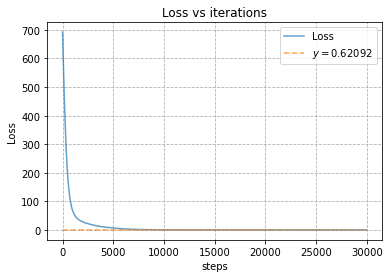

Final loss: 0.620927095413208


In [183]:
plt.plot(plot_data[:,0], plot_data[:, 1], label='Loss', alpha=0.7)
plt.plot(torch.arange(0, epochs), [0.62092]*epochs, ls='--', alpha=0.7, 
         label=r'$y=0.62092$')
plt.title('Loss vs iterations')
plt.xlabel('steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(ls='--')
plt.show()
print(f'Final loss: {plot_data[-1,1]}')

We can see that the Loss function stabilized around step $10000$ indeed, suggesting the ground energy has been reached (or a local minimum for the Loss function), and it is equal to the aforementioned $y$. 

To analyze the eigenstate, we just need to analyze the coefficients that were optimized. They are shown below, both printed out and in a diagram. 

_Remark:_ The even terms of the basis appear to have a significant distribution, while the odd terms are orders of magnitude smaller than the even terms.

tensor([ 6.0302e-01+7.8770e-01j,  2.4342e-08-1.6742e-08j,
        -7.6383e-02-9.9775e-02j,  7.4904e-08-5.1499e-08j,
         1.1858e-03+1.5490e-03j,  9.1730e-08-6.3069e-08j,
         5.3265e-03+6.9577e-03j,  1.1690e-07-8.0379e-08j,
        -2.7113e-03-3.5416e-03j,  1.5057e-07-1.0353e-07j,
         7.8510e-04+1.0255e-03j,  1.8902e-07-1.2997e-07j,
        -5.7408e-05-7.4997e-05j,  2.2691e-07-1.5601e-07j,
        -9.7103e-05-1.2685e-04j,  2.5850e-07-1.7774e-07j,
         7.7003e-05+1.0058e-04j,  2.7844e-07-1.9145e-07j,
        -3.5746e-05-4.6701e-05j,  2.8285e-07-1.9448e-07j,
         1.0268e-05+1.3407e-05j,  2.7074e-07-1.8615e-07j,
         3.8921e-08+4.4472e-08j,  2.4390e-07-1.6770e-07j,
        -2.4436e-06-3.1982e-06j,  2.0570e-07-1.4143e-07j,
         1.9656e-06+2.5638e-06j,  1.6006e-07-1.1005e-07j,
        -1.0441e-06-1.3662e-06j,  1.1116e-07-7.6427e-08j,
         3.6818e-07+4.7768e-07j,  6.3387e-08-4.3583e-08j,
        -5.2863e-08-7.2903e-08j,  2.1098e-08-1.4506e-08j,
        -6.231

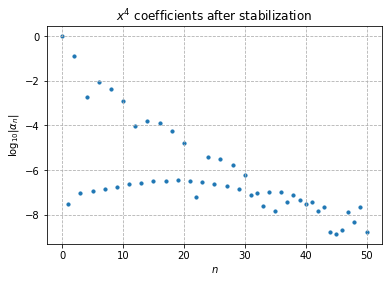

In [192]:
normed_coeffs = coeffs/torch.norm(coeffs)
print(normed_coeffs)
epsi = 1e-13  # to avoid later evaluating log(0)
plt.scatter(torch.arange(0, N+1), torch.log10(torch.abs(normed_coeffs).detach()+epsi), s=10)
plt.title(r'$x^4$ coefficients after stabilization')
plt.xlabel(r'$n$')
plt.ylabel(r'$\log_{10}|\alpha_n|$')
plt.grid(ls='--')

We can even try to find a dependency on the parameter $\lambda$, by optimizing the model with respect to different values. 

Text(0.5, 0, '$\\lambda$')

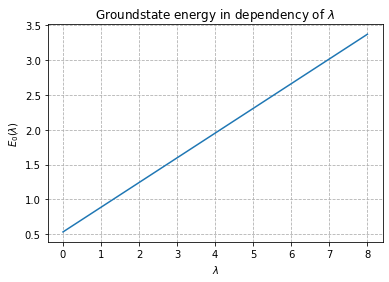

In [189]:
num_lmbdas = 24
hyperparams['epochs'] = 15000
energies = torch.zeros(num_lmbdas)
lmbdas = torch.linspace(0, 8, num_lmbdas)
for idx, lmbda in enumerate(lmbdas):
    hyperparams['lmbda'] = lmbda
    alpha = torch.rand(N+1, dtype=torch.cfloat, requires_grad=True)
    loss_info = optimize(alpha, x, H_osc, **hyperparams).detach()
    energies[idx] = loss_info[-1, 1]
plt.plot(lmbdas, energies)
plt.grid(ls='--')
plt.title(r'Groundstate energy in dependency of $\lambda$')
plt.ylabel(r'$E_0(\lambda)$')
plt.xlabel(r'$\lambda$')